<a href="https://colab.research.google.com/github/MichaelangeloVelalopoulos/diploma-energy-market/blob/main/notebooks/12hTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================================
# 0. Imports & basic setup
# ================================================
import os
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Για reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================================================
# 1. Load dataset (IDA1 only) & feature selection
# ================================================
csv_path = "/content/idm_dataset_2024.csv"   # άλλαξέ το αν χρειάζεται

df = pd.read_csv(csv_path, parse_dates=["DELIVERY_MTU"])
print(df.head())
print("Shape:", df.shape)

# Φιλτράρουμε συγκεκριμένο auction
AUCTION_NAME = "IDA1"
df_auction = df[df["AUCTION"] == AUCTION_NAME].copy()
df_auction = df_auction.sort_values("DELIVERY_MTU").reset_index(drop=True)

print(AUCTION_NAME, "rows:", len(df_auction))

# Target = MCP (IDM price)
target_col = "MCP"

# Παίρνουμε μόνο αριθμητικά columns
numeric_cols = df_auction.select_dtypes(include=[np.number]).columns

# Features: όλα τα numeric εκτός από το target
feature_cols = [c for c in numeric_cols if c != target_col]

print("Number of numeric features:", len(feature_cols))
print("Example features:", feature_cols[:20])

# ================================================
# 2. Time-based split 70/30 & scaling
# ================================================
n = len(df_auction)
split_idx = int(n * 0.7)

train_df = df_auction.iloc[:split_idx].reset_index(drop=True)
test_df  = df_auction.iloc[split_idx:].reset_index(drop=True)

print("Train rows:", len(train_df), "| Test rows:", len(test_df))

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_test  = test_df[feature_cols].values
y_test  = test_df[target_col].values

print("Raw train_features shape:", X_train.shape)
print("Raw test_features shape :", X_test.shape)

# Standardization (μόνο στα features, fit στο train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ================================================
# 3. Δημιουργία sequences για Transformer
# ================================================
input_len = 12   # πόσες προηγούμενες ώρες κοιτάει
horizon   = 1    # προβλέπουμε MCP(t+1)

def create_sequences(features, target, seq_len=24, horizon=1):
    X_seqs, y_seqs = [], []
    n = len(features)
    for i in range(n - seq_len - horizon + 1):
        X_seqs.append(features[i : i + seq_len])          # (seq_len, n_features)
        y_seqs.append(target[i + seq_len + horizon - 1])  # scalar
    return np.array(X_seqs), np.array(y_seqs)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train,
                                            seq_len=input_len, horizon=horizon)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test,
                                            seq_len=input_len, horizon=horizon)

print("X_train_seq shape:", X_train_seq.shape)  # (N_train, seq_len, n_features)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape :", X_test_seq.shape)
print("y_test_seq shape :", y_test_seq.shape)

# ================================================
# 4. PyTorch Dataset & DataLoader
# ================================================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
test_dataset  = TimeSeriesDataset(X_test_seq,  y_test_seq)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# ================================================
# 5. Positional Encoding (standard Transformer)
# ================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)          # (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (seq_len, batch, d_model)
        """
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# ================================================
# 6. Transformer-based forecaster
# ================================================
class TransformerForecast(nn.Module):
    def __init__(
        self,
        n_features,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
        input_len=24,
        out_len=1,
    ):
        super().__init__()
        self.input_len = input_len
        self.d_model = d_model

        # project raw features -> d_model
        self.input_proj = nn.Linear(n_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False,  # θα δουλέψουμε σε μορφή (seq, batch, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        self.pos_encoder = PositionalEncoding(d_model)

        # head: παίρνουμε το last time step και βγάζουμε 1 τιμή
        self.fc_out = nn.Sequential(
          nn.Linear(d_model, d_model // 2),
          nn.ReLU(),
          nn.Linear(d_model // 2, out_len)
        )


    def forward(self, x):
        """
        x: (batch, seq_len, n_features)
        """
        # project
        x = self.input_proj(x)              # (batch, seq_len, d_model)
        # reorder για Transformer: (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)
        # positional encoding
        x = self.pos_encoder(x)
        # encoder
        enc_out = self.transformer_encoder(x)   # (seq_len, batch, d_model)
        # παίρνουμε το τελευταίο timestep
        last_hidden = enc_out[-1]               # (batch, d_model)
        out = self.fc_out(last_hidden)          # (batch, 1)
        return out.squeeze(-1)                  # (batch,)

n_features = X_train_seq.shape[2]
model = TransformerForecast(
    n_features=n_features,
    d_model=128,
    nhead=8,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    input_len=input_len,
    out_len=1,
).to(device)

print(model)

# ================================================
# 7. Training loop
# ================================================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(1, epochs + 1):
    # ---- Train ----
    model.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)  # (B, seq_len, n_features)
        y_batch = y_batch.to(device)  # (B,)

        optimizer.zero_grad()
        preds = model(X_batch)        # (B,)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_mse = np.mean(train_losses)

    # ---- Evaluate on test ----
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    test_mse = mean_squared_error(all_targets, all_preds)
    test_rmse = math.sqrt(test_mse)
    test_mae = mean_absolute_error(all_targets, all_preds)

    print(
        f"Epoch {epoch:02d} | "
        f"Train MSE: {train_mse:.4f} | "
        f"Test MSE: {test_mse:.4f} | "
        f"RMSE: {test_rmse:.4f} | "
        f"MAE: {test_mae:.4f}"
    )

# ================================================
# 8. Τελική αξιολόγηση & save
# ================================================
print("\n===== ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ (Transformer IDA1) =====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)

os.makedirs("models", exist_ok=True)
model_path = "models/transformer_ida1.pt"
torch.save(model.state_dict(), model_path)
print(f"Μοντέλο αποθηκευμένο στο {model_path}")


Using device: cpu
  TARGET BIDDING_ZONE_DESCR SIDE_DESCR      DDAY ASSET_DESCR CLASSIFICATION  \
0   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
1   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
2   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
3   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   
4   IDA1    Mainland Greece        Buy  20240616        LOAD             LV   

         DELIVERY_MTU  DELIVERY_DURATION  SORT     MCP  ...  \
0 2024-06-16 00:00:00                 60     1  112.08  ...   
1 2024-06-16 01:00:00                 60     2  120.40  ...   
2 2024-06-16 02:00:00                 60     3  100.29  ...   
3 2024-06-16 03:00:00                 60     4   93.70  ...   
4 2024-06-16 04:00:00                 60     5   89.75  ...   

   AGG__mean__wind_speed_10m__rollmean3  \
0                              5.418359   
1                              5.341667   

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerForecast(
  (input_proj): Linear(in_features=92, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pos_encoder): PositionalEncoding()
  (fc_out): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=Tr


===== ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ (Transformer IDA1) =====
Test MSE : 601.1067504882812
Test RMSE: 24.517478469212147
Test MAE : 13.054621696472168


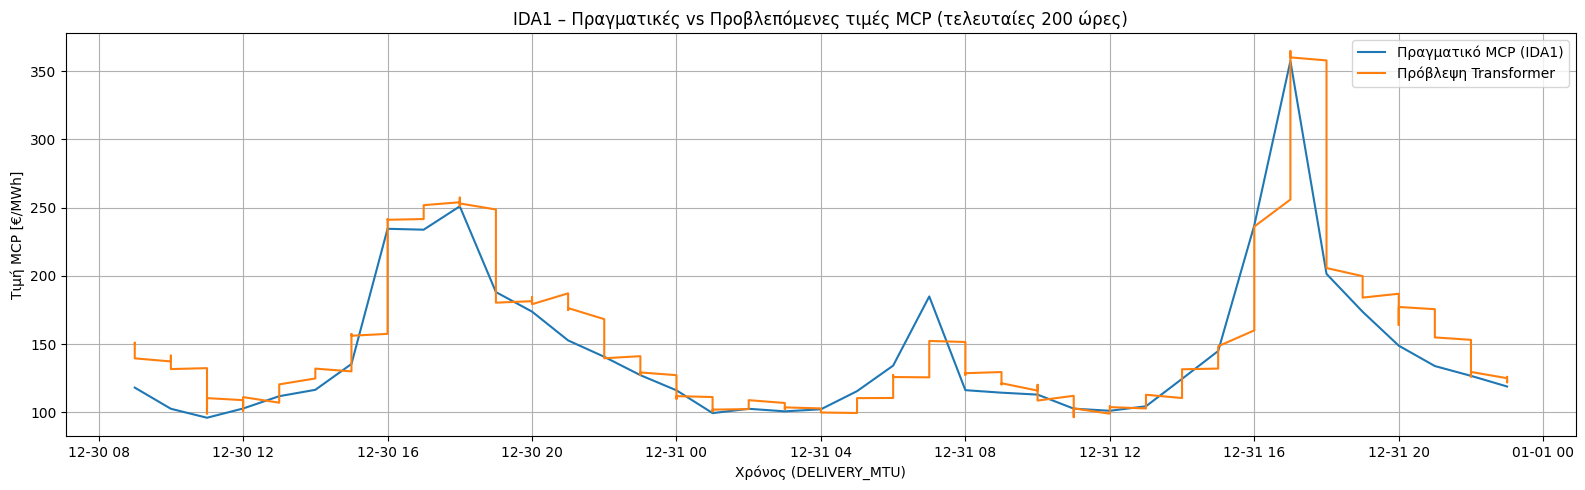

In [2]:
# ================================================
# 9. Evaluation on full test set + plot
# ================================================
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(X_batch)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Τελικές μετρικές
test_mse = mean_squared_error(all_targets, all_preds)
test_rmse = math.sqrt(test_mse)
test_mae = mean_absolute_error(all_targets, all_preds)

print("\n===== ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ (Transformer IDA1) =====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)

# --------------------------------
# Φτιάχνουμε και τον χρονικό άξονα για το test set
# --------------------------------
# Θυμήσου: test_df έχει rows σε σειρά χρόνου
# Κάθε σημείο της ακολουθίας y_test_seq αντιστοιχεί στο index:
# idx = seq_start + input_len + horizon - 1
test_times = test_df["DELIVERY_MTU"].values   # μήκος = len(test_df)
seq_times = test_times[input_len + horizon - 1 : input_len + horizon - 1 + len(all_targets)]
# τώρα len(seq_times) == len(all_targets) == len(all_preds)

# Για να είναι readable, δείχνουμε π.χ. τις τελευταίες 200 ώρες
N = 200
times_plot   = pd.to_datetime(seq_times[-N:])
targets_plot = all_targets[-N:]
preds_plot   = all_preds[-N:]

plt.figure(figsize=(16, 5))
plt.plot(times_plot, targets_plot, label="Πραγματικό MCP (IDA1)", linewidth=1.5)
plt.plot(times_plot, preds_plot,   label="Πρόβλεψη Transformer", linewidth=1.5)
plt.title("IDA1 – Πραγματικές vs Προβλεπόμενες τιμές MCP (τελευταίες 200 ώρες)")
plt.xlabel("Χρόνος (DELIVERY_MTU)")
plt.ylabel("Τιμή MCP [€/MWh]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
